In [1]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Conv2DTranspose, Concatenate, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K 
import tensorflow as tf

2023-06-05 17:12:02.429795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
#General variables

simple = False
train_amount = 0.75
filters = 16
classes = 2

#1 Importando Dataset

In [3]:
#Data
import numpy as np
import os
import cv2
from tensorflow.keras.utils import image_dataset_from_directory

In [4]:
if simple:
  if not os.path.isdir("mask"):
    !unzip data.zip

  input_path = os.listdir("img/")
  masks = []
  imgs = []
  norm = 0
  vali = 0
  for file in input_path:
      img_path = os.path.join("img/", file)
      mask_path = os.path.join("mask/", file)
      img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2GRAY)
      mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2GRAY)
      #img = cv2.resize(img, (512, 512))
      #mask = cv2.resize(mask, (512, 512))
      img = np.asarray(img)
      mask = np.asarray(mask)
      imgs.append(img)
      masks.append(mask)


  total_samples = imgs.shape[0]
  toTrain = int(train_amount * total_samples)
  X = imgs[:,:,:toTrain]
  X_val = imgs[:,:,toTrain:]
  y = masks[:,:,:toTrain]
  y_val = masks[:,:,toTrain:]

else:
  import nibabel as nib

  datasets_path = "./datasets/tomo"
  imgs_path = os.path.join(datasets_path, "img/volume_pt1")
  masks_path = os.path.join(datasets_path, "mask")

  volumes_num = 1
  total_volumes = volumes_num*2


  images_path = [f"{imgs_path}/volume-{i}.nii" for i in range(total_volumes)]
  masks_path = [f"{masks_path}/segmentation-{i}.nii" for i in range(total_volumes)]
  imgs = []
  masks = []
  for file in images_path:
      img = nib.load(file).get_fdata()
      for i in range(img.shape[2]):
          imgs.append(img[:,:,i])
  imgs = np.array(imgs)


  for file in masks_path:
      img = nib.load(file).get_fdata()
      for i in range(img.shape[2]):
          masks.append(img[:,:,i])
  masks = np.array(masks)
  print(masks.shape)

  total_samples = imgs.shape[0]
  print(total_samples)
  toTrain = int(train_amount * total_samples)
  toVal = total_samples - toTrain

  X = imgs[:toTrain,:,:]
  X_val = imgs[toTrain:,:,:]
  y = masks[:toTrain,:,:]
  y_val = masks[toTrain:,:,:]

  print(X.shape, X_val.shape, y.shape, y_val.shape)

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


FileNotFoundError: [Errno 2] No such file or directory: 'img/'

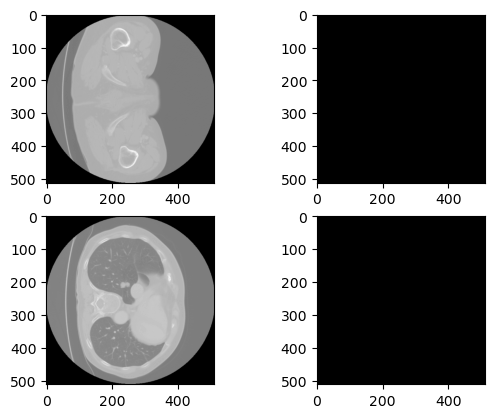

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X[1], cmap = 'gray')
axarr[0,1].imshow(y[1,:,:], cmap = 'gray')
axarr[1,0].imshow(X_val[1], cmap = 'gray')
axarr[1,1].imshow(y_val[1,:,:], cmap = 'gray')

plt.show()

#2 Criando a arquitetura

In [ ]:
#Definindo dice coeficiente
def dice_coefficient(y_true, y_pred, smooth=1):
    num_classes = K.int_shape(y_pred)[-1]
    dice = 0
    for index in range(num_classes):    
        y_true_class = y_true[..., index]
        y_pred_class = y_pred[..., index]
        y_true_class = K.cast(y_true_class, dtype='float32')  # Convert y_true to float32
        intersection = K.sum(K.abs(y_true_class * y_pred_class), axis=-1)
        union = K.sum(y_true_class, axis=-1) + K.sum(y_pred_class, axis=-1)
        dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    loss = 1 - dice_coefficient(y_true, y_pred)
    return loss

In [ ]:
input = Input((512, 512,1))

conv1 = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(input)
# Including batch normalization as possible fix to all black prediction
#conv1 = BatchNormalization()(conv1)
conv1_ = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv1)
#conv1 = BatchNormalization()(conv1)
pool1 = MaxPooling2D(pool_size = (2,2))(conv1)

pool1.shape

TensorShape([None, 256, 256, 32])

In [ ]:
conv2 = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool1)
#conv2 = BatchNormalization()(conv2)
conv2 = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv2)
#conv2 = BatchNormalization()(conv2)
pool2 = MaxPooling2D(pool_size = (2,2))(conv2)

pool2.shape

TensorShape([None, 128, 128, 64])

In [ ]:
conv3 = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool2)
#conv3 = BatchNormalization()(conv3)
conv3 = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv3)
#conv3 = BatchNormalization()(conv3)
pool3 = MaxPooling2D(pool_size = (2,2))(conv3)

pool3.shape

TensorShape([None, 64, 64, 128])

In [ ]:
conv4 = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool3)
#conv4 = BatchNormalization()(conv4)
conv4 = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv4)
#conv4 = BatchNormalization()(conv4)
#drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size = (2,2))(conv4)

pool4.shape

TensorShape([None, 32, 32, 256])

In [ ]:
conv5 = Conv2D(filters*32, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Conv2D(filters*32, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv5)
conv5 = BatchNormalization()(conv5)
#drop5 = Dropout(0.5)(conv5)

conv5.shape

TensorShape([None, 32, 32, 512])

In [ ]:
convUp = Conv2DTranspose(filters*16, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(conv5)
convUp = Concatenate()([convUp, conv4])
convUp = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*16, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 64, 64, 256])

In [ ]:
convUp = Conv2DTranspose(filters*8, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Concatenate()([convUp, conv3])
convUp = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*8, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 128, 128, 128])

In [ ]:
convUp = Conv2DTranspose(filters*4, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Concatenate()([convUp, conv2])
convUp = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*4, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 256, 256, 64])

In [ ]:
convUp = Conv2DTranspose(filters*2, (2,2), strides = (2,2), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Concatenate()([convUp, conv1])
convUp = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)
convUp = Conv2D(filters*2, (3,3), padding = 'same', activation = 'relu', kernel_initializer = 'he_uniform')(convUp)


convUp.shape

TensorShape([None, 512, 512, 32])

In [ ]:
if classes == 2:
    output = Conv2D(1, (1,1), activation = 'sigmoid', kernel_initializer = 'he_uniform')(convUp)
else:
    output = Conv2D((classes), (1,1), activation = 'softmax', kernel_initializer = 'he_uniform')(convUp)
output.shape

model = Model(inputs = [input], outputs = [output])
#Now using MeanIoU instead of accuracy
'''
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy', 
                         MeanIoU(num_classes=2, name = 'MeanIoU', ignore_class=0)])
'''
#Using only dice
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3), 
              loss = [dice_loss], #loss = [dice_loss]
              metrics = [dice_coefficient])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 512, 512, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 512, 512, 32  320         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_12 (MaxPooling2D  (None, 256, 256, 32  0          ['conv2d_57[0][0]']              
 )                              )                                                           

In [ ]:
tf.keras.utils.plot_model(model, "model.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


#3 Treinando a rede

In [ ]:
checkpoint = ModelCheckpoint(filepath='model.h5', save_freq = 'epoch')
#model.load_weights("model.h5")
history = model.fit(X, y, epochs=50, batch_size = 8, callbacks = [checkpoint], validation_data=(X_val, y_val))

Epoch 1/50
19/19 [==============================] - 420s 22s/step - loss: 0.9426 - dice_coefficient: 0.0574 - val_loss: 0.9575 - val_dice_coefficient: 0.0425
Epoch 2/50
19/19 [==============================] - 458s 24s/step - loss: 0.7699 - dice_coefficient: 0.2301 - val_loss: 0.9065 - val_dice_coefficient: 0.0935
Epoch 3/50
11/19 [================>.............] - ETA: 3:09 - loss: 0.7346 - dice_coefficient: 0.2654

KeyboardInterrupt: 

#4 Testes

In [ ]:
#model = tf.keras.models.load_model('model.31.h5')
a = X_val[0:10]
test = model.predict(a)
#X_val.shape

1/1 [==============================] - 0s 355ms/step


In [ ]:
image_id = 7

f, axarr = plt.subplots(2,2)
axarr[0,0].imshow(X_val[image_id], cmap = 'gray')
axarr[0,1].imshow(y_val[image_id,:,:], cmap = 'gray')
axarr[1,0].imshow(X_val[image_id], cmap = 'gray')
axarr[1,1].imshow(test[image_id,:,:], cmap = 'gray')

plt.show()

In [ ]:
import pickle


with open('trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)